In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%env OMP_NUM_THREADS=20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: OMP_NUM_THREADS=20


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import math as math

In [8]:
import covmat_CMB_S4 as covmat

ModuleNotFoundError: No module named 'fishchips'

In [4]:
from collections import defaultdict
import numpy as np
import fishchips
from scipy import linalg
import fishchips.experiments
import fishchips.cmb_lensing
import math

ModuleNotFoundError: No module named 'fishchips'

In [5]:
from cobaya.model import get_model

ModuleNotFoundError: No module named 'cobaya'

In [9]:
def δ(α, β):
    return np.array(α==β, dtype=float)

def cov_2pt(signal_dict, noise_dict, bin_left, bin_right=None, 
            f_sky=0.6, N_splits=2,
            instruments=('Planck', 'Planck', 'Planck', 'Planck'), 
            observables=('T', 'T', 'T', 'T'), 
            seasons=(0,0,0,0),
            verbose=True):
    """Compute a covariance matrix for a 2-pt correlation function.
    
    This is an implementation of equation B2 in arXiv:1610.02360.
    
    signal_dict : dict
        Must have tuple keys for all two-point (T/E/B/κ) pairs
        i.e. a key could be ('T', 'E').
    noise_dict : dict
        Must have tuple keys in the format
            (season, instrument, season, instrument, T/E/B/κ, T/E/B/κ)
        If you have only one season, set every season value to 0.
    """
    
    # if bin_right is not specified, bin_right[n] = bin_left[n+1]
    if bin_right == None: 
        Δbin = bin_left[-1] - bin_left[-2] # last bin-width
        bin_right = np.hstack((np.array(bin_left[1:]), [bin_left[-1]+Δbin]))
        
    A, B, C, D = instruments
    W, X, Y, Z = observables
    α, β, γ, τ = seasons
    
    N_s = N_splits
    n_b = len(bin_left)
    
    # assume zero signal and infinite noise for non-specified terms
    S_b = defaultdict(lambda:0.0, signal_dict)
    N_b = defaultdict(lambda:np.inf, noise_dict)
    
    ν_b = np.zeros(n_b)
    for i, (bl, br) in enumerate(zip(bin_left, bin_right)):
        ν_b[i] = np.sum(2 * np.arange(bl, br) + 1) * f_sky
    
    # deliberately not PEP8, I think this is more readable
    sum1 = S_b[W,Y] * S_b[X,Z] + S_b[W,Z] * S_b[X,Y]
    
    sum2 = (
        S_b[W,Y] * δ(β,τ) * N_b[β,B,τ,D,X,Z] + 
        S_b[X,Z] * δ(α,γ) * N_b[α,A,γ,C,W,Y] +
        S_b[W,Z] * δ(β,γ) * N_b[β,B,γ,C,X,Y] + 
        S_b[X,Y] * δ(α,τ) * N_b[α,A,τ,D,W,Z]
    )
    
    sum3 = (
        δ(α,γ) * δ(β,τ) * N_b[α,A,γ,C,W,Y] * N_b[β,B,τ,D,X,Z] +
        δ(β,γ) * δ(α,τ) * N_b[α,A,τ,D,W,Z] * N_b[β,B,γ,C,X,Y]
    )
    
    prefactor_3 = (1/ν_b) * (
        (N_s**2 - N_s * (δ(α,β) + δ(γ,τ)) + N_s * δ(α,β) * δ(γ,τ)) /
        (N_s**4 - N_s**3 * (δ(α,β) + δ(γ,τ)) + N_s**2 * δ(α,β) * δ(γ,τ))
    )
    
    return (1/ν_b) * sum1 + (1/(N_s * ν_b)) * sum2 + prefactor_3 * sum3

In [10]:
fiducial_params = {
    'omega_b': 0.0224, 'omega_dmeff': 0.12, 
    '100*theta_s': 1.0416, 'tau_reio': 0.07,
    'A_s': 2.2e-9, 'n_s': 0.96,
    'N_ur': 2.0328, 'N_ncdm': 1, 'm_ncdm': 0.06, 'T_ncdm': 0.71611,}
l_min = 2
l_max = 2500

modules_path = '/home/zequnl/src/cobaya_modules'

info_fiducial = {
    'params': fiducial_params,
    'likelihood': {'one': None},
    'theory': {
        'classy': {'extra_args': 
                    {  'output': 'tCl, pCl, lCl, mPk',
                        'l_max_scalars': 5000,
                        'lensing': 'yes', 
                        'omega_cdm':1e-22,
                        'm_dmeff': 1,
                        'npow_dmeff' : 0,
                        'sigma_dmeff' : 8.1714275e-27,
                     
                        'reionization_optical_depth_tol': 1e-07,
                        'perturb_sampling_stepsize':0.01,
                         'k_max_tau0_over_l_max' : 6,
                         'P_k_max_h/Mpc' : 5.,
                         'gauge' : 'synchronous',
                         'k_per_decade_for_pk' : 100
                    } 
                  } 
        
    }
}


from cobaya.model import get_model
model_fiducial = get_model(info_fiducial)

# Declare our desired theory product
# (there is no cosmological likelihood doing it for us)
model_fiducial.likelihood.theory.needs(Cl={'tt': l_max, 'ee': l_max, 'pp':l_max})

# Compute and extract the CMB power spectrum
# (In muK^-2, without l(l+1)/(2pi) factor)
# notice the empty dictionary below: all parameters are fixed
model_fiducial.logposterior({})
Cls = model_fiducial.likelihood.theory.get_Cl(ell_factor=False)

# Our fiducial power spectrum
Cl_est_tt = Cls['tt'][:l_max+1]
Cl_est_ee = Cls['ee'][:l_max+1]
Cl_est_pp = Cls['pp'][:l_max+1]
Ell = Cls['ell'][:l_max+1]
Cl_est_kk = []
for i in Ell:
    if i < 2:
        Cl_est_kk.append(0)
    else:
        Cl_est_kk.append(1/4*(math.factorial(i+2)/math.factorial(i-2))*Cl_est_pp[i])

ModuleNotFoundError: No module named 'cobaya'

In [16]:
np.save('Cl_tt_n_0_1GeV', Cl_est_tt)
np.save('Cl_ee_n_0_1GeV', Cl_est_ee)
np.save('Cl_pp_n_0_1GeV', Cl_est_pp)
np.save('Cl_kk_n_0_1GeV', Cl_est_kk)

In [8]:
def noise_Planck_Pol(l_max = 2500):
    
    exper = fishchips.experiments.get_PlanckPol_combine()
    Nltt = np.concatenate((exper[0].noise_T, exper[1].noise_T[31:], exper[2].noise_T[101:]))[:l_max+1]
    Nlee = np.concatenate((exper[1].noise_P, exper[2].noise_P[101:]))[:l_max+1]
    Nlkk = fishchips.cmb_lensing.CMB_Lensing_Only().noise_k[:l_max+1]
    
    return np.array([Nltt, Nlee, Nlkk])

def noise_CMB_S4(l_max = 2500):
    exper = fishchips.experiments.get_S4()
    Nltt = exper[1].noise_T[:l_max+1]
    Nlee = np.concatenate((exper[0].noise_P, exper[1].noise_P[301:3001], exper[2].noise_P[3001:]))[:l_max+1]
    Nlkk = fishchips.experiments.get_S4_Lensing_Only().noise_k[:l_max+1]
    
    return np.array([Nltt, Nlee, Nlkk])

In [9]:
def calculate_covmat(experiment, l_min = 2, l_max = 2500):
    #model_fiducial = fiducial_model();
    Cltt = model_fiducial.likelihood.theory.get_Cl(ell_factor=False)['tt'][:l_max+1]
    Clee = model_fiducial.likelihood.theory.get_Cl(ell_factor=False)['ee'][:l_max+1]
    Clte = model_fiducial.likelihood.theory.get_Cl(ell_factor=False)['te'][:l_max+1]
    Clpp = model_fiducial.likelihood.theory.get_Cl(ell_factor=False)['pp'][:l_max+1]
    Ell = model_fiducial.likelihood.theory.get_Cl(ell_factor=False)['ell'][:l_max+1]
    Clkk = []
    for i in Ell:
        if i <= 2:
            Clkk.append(0)
        else:
            Clkk.append(1/4*(math.factorial(i+2)/math.factorial(i-2))*Clpp[i-2])
    Clkk = np.array(Clkk) 
    Cltk = np.zeros(len(Ell))
    Clke = np.zeros(len(Ell))
    
    if experiment == "Planck":
        noise_array = noise_Planck_Pol()
    elif experiment == "CMB-S4":
        noise_array = noise_CMB_S4()
        
    Nltt = noise_array[0]
    Nlee = noise_array[1]
    Nlkk = noise_array[2]
    Nlte = np.zeros(l_max+1)[:l_max+1]
    Nltk = np.zeros(l_max+1)[:l_max+1]
    Nlke = np.zeros(l_max+1)[:l_max+1]
    
    # calculate the components with temperature (T) and polarization (E)
    covTTTT = cov_2pt(
        {('T', 'T'): Cltt},
        {(0, 'S4', 0, 'S4', 'T', 'T'): Nltt},
        bin_left=np.arange(l_max+1),
        observables=('T', 'T', 'T', 'T'), 
        instruments=('S4', 'S4', 'S4', 'S4'), 
        seasons=(0,0,0,0) # season is always 0 here
    )
    covTTTE = cov_2pt(
        {('T', 'T'): Cltt, ('E', 'E'): Clee,
         ('T', 'E'): Clte, ('E', 'T'): Clte},
        {(0, 'S4', 0, 'S4', 'T', 'T'): 
         Nltt, 
        (0, 'S4', 0, 'S4', 'E', 'E'): 
         Nlee,
        (0, 'S4', 0, 'S4', 'T', 'E'): 
         Nlte,
        (0, 'S4', 0, 'S4', 'E', 'T'): 
         Nlte
        },
        bin_left=np.arange(l_max+1),
        observables=('T', 'T', 'T', 'E'), 
        instruments=('S4', 'S4', 'S4', 'S4'), 
        seasons=(0,0,0,0) # season is always 0 here
    )
    covTETT = covTTTE

    covTTEE = cov_2pt(
        {('T', 'T'):
          Cltt, 
         ('E', 'E'): 
          Clee,
         ('T', 'E'): 
          Clte,
         ('E', 'T'): 
          Clte
        },
        {(0, 'S4', 0, 'S4', 'T', 'T'): 
         Nltt, 
        (0, 'S4', 0, 'S4', 'E', 'E'): 
         Nlee,
        (0, 'S4', 0, 'S4', 'T', 'E'): 
         Nlte,
        (0, 'S4', 0, 'S4', 'E', 'T'): 
         Nlte
        },
        bin_left=np.arange(l_max+1),
        observables=('T', 'T', 'E', 'E'), 
        instruments=('S4', 'S4', 'S4', 'S4'), 
        seasons=(0,0,0,0) # season is always 0 here
    )
    covEETT = covTTEE


    covTETE = cov_2pt(
        {('T', 'T'):
          Cltt, 
         ('E', 'E'): 
          Clee,
         ('T', 'E'): 
          Clte,
         ('E', 'T'): 
          Clte
        },
        {(0, 'S4', 0, 'S4', 'T', 'T'): 
         Nltt, 
        (0, 'S4', 0, 'S4', 'E', 'E'): 
         Nlee,
        (0, 'S4', 0, 'S4', 'T', 'E'): 
         Nlte,
        (0, 'S4', 0, 'S4', 'E', 'T'): 
         Nlte
        },
        bin_left=np.arange(l_max+1),
        observables=('T', 'E', 'T', 'E'), 
        instruments=('S4', 'S4', 'S4', 'S4'), 
        seasons=(0,0,0,0) # season is always 0 here
    )

    covTEEE = cov_2pt(
        {('T', 'T'):
          Cltt, 
         ('E', 'E'): 
          Clee,
         ('T', 'E'): 
          Clte,
         ('E', 'T'): 
          Clte
        },
        {(0, 'S4', 0, 'S4', 'T', 'T'): 
         Nltt, 
        (0, 'S4', 0, 'S4', 'E', 'E'): 
         Nlee,
        (0, 'S4', 0, 'S4', 'T', 'E'): 
         Nlte,
        (0, 'S4', 0, 'S4', 'E', 'T'): 
         Nlte
        },
        bin_left=np.arange(l_max+1),
        observables=('T', 'E', 'E', 'E'), 
        instruments=('S4', 'S4', 'S4', 'S4'), 
        seasons=(0,0,0,0) # season is always 0 here
    )
    covEETE = covTEEE

    covEEEE = cov_2pt(
        {('E', 'E'): Clee},
        {(0, 'S4', 0, 'S4', 'E', 'E'): Nlee},
        bin_left=np.arange(l_max+1),
        observables=('E', 'E', 'E', 'E'), 
        instruments=('S4', 'S4', 'S4', 'S4'), 
        seasons=(0,0,0,0) # season is always 0 here
    )
    
    # Compute components with lensing (K)
    covKKKK = cov_2pt(
        {('K', 'K'): Clkk},
        {(0, 'S4', 0, 'S4', 'K', 'K'): Nlkk},
        bin_left=np.arange(l_max+1),
        observables=('K', 'K', 'K', 'K'), 
        instruments=('S4', 'S4', 'S4', 'S4'), 
        seasons=(0,0,0,0) # season is always 0 here
    )

    covTTKK = cov_2pt(
        {('T', 'T'):
          Cltt, 
         ('K', 'K'): 
          Clkk,
         ('T', 'K'): 
          Cltk,
         ('K', 'T'): 
          Cltk
        },
        {(0, 'S4', 0, 'S4', 'T', 'T'): 
         Nltt, 
        (0, 'S4', 0, 'S4', 'K', 'K'): 
         Nlkk,
        (0, 'S4', 0, 'S4', 'T', 'K'): 
         Nltk,
        (0, 'S4', 0, 'S4', 'K', 'T'): 
         Nltk
        },
        bin_left=np.arange(l_max+1),
        observables=('T', 'T', 'K', 'K'), 
        instruments=('S4', 'S4', 'S4', 'S4'), 
        seasons=(0,0,0,0) # season is always 0 here
    )
    covKKTT = covTTKK

    covTEKK = cov_2pt(
        {('T', 'T'): Cltt, ('K', 'K'): Clkk, ('E', 'E'): Clee,
         ('T', 'E'): Clte, ('E', 'T'): Clte,
         ('T', 'K'): Cltk, ('K', 'T'): Cltk, 
         ('E', 'K'): Clke, ('K', 'E'): Clke, 
        },
        {(0, 'S4', 0, 'S4', 'T', 'T'): 
         Nltt, 
        (0, 'S4', 0, 'S4', 'E', 'E'): 
         Nlee,
        (0, 'S4', 0, 'S4', 'K', 'K'): 
         Nlkk,
        (0, 'S4', 0, 'S4', 'T', 'E'): 
         Nlte,
        (0, 'S4', 0, 'S4', 'E', 'T'): 
         Nlte,
        (0, 'S4', 0, 'S4', 'E', 'K'): 
         Nlke,
        (0, 'S4', 0, 'S4', 'K', 'E'): 
         Nlke,
        (0, 'S4', 0, 'S4', 'K', 'T'):
         Nltk,
        (0, 'S4', 0, 'S4', 'T', 'K'): 
         Nltk
        },
        bin_left=np.arange(l_max+1),
        observables=('T', 'E', 'K', 'K'), 
        instruments=('S4', 'S4', 'S4', 'S4'), 
        seasons=(0,0,0,0) # season is always 0 here
    )
    covKKTE = covTEKK

    covEEKK = cov_2pt(
        {('E', 'E'):
          Clee, 
         ('K', 'K'): 
          Clkk,
         ('E', 'K'): 
          Clke,
         ('K', 'E'): 
          Clke
        },
        {(0, 'S4', 0, 'S4', 'K', 'K'): 
         Nlkk, 
        (0, 'S4', 0, 'S4', 'E', 'E'): 
         Nlee,
        (0, 'S4', 0, 'S4', 'K', 'E'): 
         Nlke,
        (0, 'S4', 0, 'S4', 'E', 'K'): 
         Nlke
        },
        bin_left=np.arange(l_max+1),
        observables=('E', 'E', 'K', 'K'), 
        instruments=('S4', 'S4', 'S4', 'S4'), 
        seasons=(0,0,0,0) # season is always 0 here
    )
    covKKEE = covEEKK

    cov = np.block([[np.diag(covTTTT[l_min:]), np.diag(covTTTE[l_min:]), np.diag(covTTEE[l_min:]), np.diag(covTTKK[l_min:])],
                   [np.diag(covTETT[l_min:]), np.diag(covTETE[l_min:]), np.diag(covTEEE[l_min:]), np.diag(covTEKK[l_min:])], 
                   [np.diag(covEETT[l_min:]), np.diag(covEETE[l_min:]), np.diag(covEEEE[l_min:]), np.diag(covEEKK[l_min:])], 
                   [np.diag(covKKTT[l_min:]), np.diag(covKKTE[l_min:]), np.diag(covKKEE[l_min:]), np.diag(covKKKK[l_min:])]])

    invcov = linalg.cho_solve( linalg.cho_factor(cov), b = np.identity(cov.shape[0]) )
    sign_of_logdet, logdet = np.linalg.slogdet(cov)
    return invcov, sign_of_logdet, logdet

In [10]:
invcov_Planck, sign_of_logdet_Planck, logdet_Planck = calculate_covmat("Planck")

Generating theory Cls...


In [11]:
invcov_CMB_S4, sign_of_logdet_CMB_S4, logdet_CMB_S4 = calculate_covmat("CMB-S4");

Generating theory Cls...


In [12]:
def my_like_CMB_S4(#invcov, sign_of_logdet, logdet,
        # Parameters that we may sample over (or not)
#         beam_FWHM=0.1,  # deg
        # Declaration of our theory requirements
        _theory={'Cl': {'tt': 2500, 'ee': 2500, 'te':2500, 'pp':2500}},
        # Declaration of available derived parameters
        _derived={}):
    l_min =2 
    l_max = 2500
    Cls = model_fiducial.likelihood.theory.get_Cl(ell_factor=False)
    Cl_est_kk = []
    for i in Cls['ell']:
        if i < 2:
            Cl_est_kk.append(0)
        else:
            Cl_est_kk.append(1/4*(math.factorial(i+2)/math.factorial(i-2))*Cls['pp'][i])
            
    Ell = _theory.get_Cl(ell_factor=False)['ell'][l_min:l_max+1]
    Cltt = _theory.get_Cl(ell_factor=False)['tt'][:l_max+1]
    Clee = _theory.get_Cl(ell_factor=False)['ee'][:l_max+1]
    Clte = _theory.get_Cl(ell_factor=False)['te'][:l_max+1]
    Clpp = _theory.get_Cl(ell_factor=False)['pp'][l_min:l_max+1]
    Clkk = []
    #for i in Ell:
     #   if i < 2:
      #      Clkk.append(0)
      #  else:
      #      Clkk.append(1/4*(math.factorial(i+2)/math.factorial(i-2))*Clpp[i-2])
    Clkk = 0.25*(Ell+2)*(Ell+1)*(Ell)*(Ell-1)*Clpp 
    ## TRY WRITING CLKK with ARRAY
    
    
    diff_vec_tt = (Cltt - Cls['tt'][:l_max+1])[l_min:]
    # Cl_est is fiducial (i.e. data in the forecasting case)
    diff_vec_te = (Clte - Cls['te'][:l_max+1])[l_min:]
    diff_vec_ee = (Clee - Cls['ee'][:l_max+1])[l_min:]
    diff_vec_kk = (Clkk - Cl_est_kk[l_min:])
    diff_vec = np.concatenate((diff_vec_tt, diff_vec_te, diff_vec_ee, diff_vec_kk))
    
#     return diff_vec, cov
    
    ptemp = np.dot(invcov_CMB_S4, diff_vec)
    like = np.sum(ptemp * diff_vec)
    
    return -(like + sign_of_logdet_CMB_S4 * logdet_CMB_S4) / 2.0

def my_like_Planck_Pol(#invcov, sign_of_logdet, logdet,
        # Parameters that we may sample over (or not)
#         beam_FWHM=0.1,  # deg
        # Declaration of our theory requirements
        _theory={'Cl': {'tt': 2500, 'ee': 2500, 'te': 2500, 'pp': 2500}},
        # Declaration of available derived parameters
        _derived={}):
    l_min = 2 
    l_max = 2500
    Cls = model_fiducial.likelihood.theory.get_Cl(ell_factor=False)
    Cl_est_kk = []
    for i in Cls['ell']:
        if i < 2:
            Cl_est_kk.append(0)
        else:
            Cl_est_kk.append(1/4*(math.factorial(i+2)/math.factorial(i-2))*Cls['pp'][i])
    
    Ell = _theory.get_Cl(ell_factor=False)['ell'][l_min:l_max+1]
    Cltt = _theory.get_Cl(ell_factor=False)['tt'][:l_max+1]
    Clee = _theory.get_Cl(ell_factor=False)['ee'][:l_max+1]
    Clte = _theory.get_Cl(ell_factor=False)['te'][:l_max+1]
    Clpp = _theory.get_Cl(ell_factor=False)['pp'][l_min:l_max+1]
    Clkk = []
    #for i in Ell:
     #   if i < 2:
      #      Clkk.append(0)
      #  else:
      #      Clkk.append(1/4*(math.factorial(i+2)/math.factorial(i-2))*Clpp[i-2])
    Clkk = 0.25*(Ell+2)*(Ell+1)*(Ell)*(Ell-1)*Clpp 
    ## TRY WRITING CLKK with ARRAY
    
    
    diff_vec_tt = (Cltt - Cls['tt'][:l_max+1])[l_min:]
    # Cl_est is fiducial (i.e. data in the forecasting case)
    diff_vec_te = (Clte - Cls['te'][:l_max+1])[l_min:]
    diff_vec_ee = (Clee - Cls['ee'][:l_max+1])[l_min:]
    diff_vec_kk = (Clkk - Cl_est_kk[l_min:])
    diff_vec = np.concatenate((diff_vec_tt, diff_vec_te, diff_vec_ee, diff_vec_kk))
    
#     return diff_vec, cov
    
    ptemp = np.dot(invcov_Planck, diff_vec)
    like = np.sum(ptemp * diff_vec)
    
    return -(like + sign_of_logdet_Planck * logdet_Planck) / 2.0

In [13]:
my_like_CMB_S4(_theory=model_fiducial.likelihood.theory)

-24858.98834902431

In [14]:
my_like_Planck_Pol(_theory=model_fiducial.likelihood.theory)

80189.24857852836

In [15]:
info = {
    'params': { 
        # Fixed
        'N_ur': 2.0328, 'N_ncdm': 1, 'm_ncdm': 0.06, 'T_ncdm': 0.71611, 
        # Sampled
        
        'logA': {
            'prior': {'min': 1.61, 'max': 3.91}, 
            'ref' : {'dist' : 'norm', 'loc' : 3.05, 'scale' : 0.001},
            'proposal' : 0.001,
            'latex': '\log(10^{10} A_\mathrm{s})', 
            'drop': True
        },
        'n_s': {
            'prior': {'min': 0.9, 'max': 1.1}, 
            'ref' : {'dist' : 'norm', 'loc' : 0.96, 'scale' : 0.004},
            'proposal' : 0.002,
            'latex': 'n_s'
        },
        'omega_b': {
            'prior': {'min': 0.005, 'max': 0.1}, 
            'ref' : {'dist' : 'norm', 'loc' : 0.0224, 'scale' : 0.0001},
            'proposal' : 0.0001,
            'latex': '\Omega_\mathrm{b} h^2'
        },
        'omega_dmeff': {
            'prior': {'min': 0.001, 'max': 0.99}, 
            'ref' : {'dist' : 'norm', 'loc' : 0.1197, 'scale' : 0.001},
            'proposal' : 0.0005,
            'latex': '\Omega_\mathrm{c} h^2'
        },
        'sigma_dmeff': {
            'prior': {'min': 0, 'max': 8e-26}, 
            'ref' : {'dist' : 'norm', 'loc' : 0, 'scale' : 8e-27},
            'proposal' : 5e-27 # x 5-sigma from the cov matrix 
            #'latex': '\sigma_{dmeff}'
         },
        'theta_s_1e2' : {
            'prior': {'min': 0.5, 'max': 10.0}, 
            'ref' : {'dist' : 'norm', 'loc' : 1.0416, 'scale' : 0.0004},
            'proposal' : 0.0002,
            'latex': '100\theta_\mathrm{s}', 
            'drop': True
        },
        '100*theta_s' : {
            'value': 'lambda theta_s_1e2: theta_s_1e2',
            'derived': False
        },
        'tau_reio': {
            'prior': {'min': 0.01, 'max': 0.10}, #max: 0.08
            'ref' : {'dist' : 'norm', 'loc' : 0.07, 'scale' : 0.006},
            'proposal' : 0.003,
            'latex': '\tau_\mathrm{reio}'
        },
        # Derived
        
        'A_s': {'value':'lambda logA: 1e-10*np.exp(logA)', 'latex': 'A_s'},
        'H0' : {'latex':'H_0'},
        #'sigma_dmeff': {'latex':'sigma_{dmeff}'},
        
    },
    'likelihood': {'my_cl_like': my_like_CMB_S4, 'my_cl_like_2': my_like_Planck_Pol},
    'theory': {'classy' : 
                   {'extra_args': 
                    {  'output': 'tCl,pCl,lCl,mPk',
                        'l_max_scalars': 5000,
                        'lensing': 'yes',
                        'omega_cdm':1e-22,
                        'm_dmeff': 1,
                        'npow_dmeff' : 0,


                        #'tight_coupling_trigger_tau_c_over_tau_k':0.,
                        #'tight_coupling_trigger_tau_c_over_tau_h':0.,
                        'reionization_optical_depth_tol': 1e-07,
#                         'tol_background_integration': 1e-8,
#                         'tol_perturb_integration': 1e-8,
#                         'tol_thermo_integration': 1e-9,
                        'perturb_sampling_stepsize':0.01,
                        'k_max_tau0_over_l_max' : 6,
                        'P_k_max_h/Mpc' : 5.,
                        'gauge' : 'synchronous',
                        'k_per_decade_for_pk' : 100}
                   }
              },
    'sampler': {
        'mcmc': {
            'covmat' : '/home/aizhana/cmb-mocks/notebooks/n_0_all_experiments/chains/n_0/class_bluebook_CMB_S4_1_1.covmat',
            'proposal_scale' : 2.4
        }
    },
#     'sampler': {
#         'polychord': None
#     },  # or polychord...

    'resume' : True,
#     'force' : True,
    
#     'modules': modules_path,
    'output': 'chains/class_bluebook_CMB_S4_1'}

In [16]:
from cobaya.model import get_model
model = get_model(info)


[model] *WARNING* Ignored blocks/options: ['sampler', 'resume', 'output']
[my_cl_like] Initialised external likelihood.
[my_cl_like_2] Initialised external likelihood.
[classy] Importing *global* CLASS.
[classy] *WARNING* Requesting BB for ell>50 or lensing Cl's: using a non-linear code is recommended (and you are not using any). To activate it, set 'non_linear: halofit|hmcode|...' in classy's 'extra_args'.
[classy] *WARNING* Requesting BB for ell>50 or lensing Cl's: using a non-linear code is recommended (and you are not using any). To activate it, set 'non_linear: halofit|hmcode|...' in classy's 'extra_args'.
[likelihood] The theory code will compute the following products, requested by the likelihoods: ['H0', 'Cl']


In [17]:
def likelihood_slice(sigma_dmeff):
    fiducial_params = {'omega_b': 0.0224, 'omega_dmeff': 0.1197,
                         'tau_reio': 0.07,
                        'n_s': 0.96, 'logA':3.05, 'theta_s_1e2': 1.0416, 'sigma_dmeff': sigma_dmeff}
    return model.loglike(fiducial_params)
    

In [70]:
sigmas = 1e-27*np.linspace(0, 100, 10)
likelihoods = [likelihood_slice(i)[0] for i in sigmas]

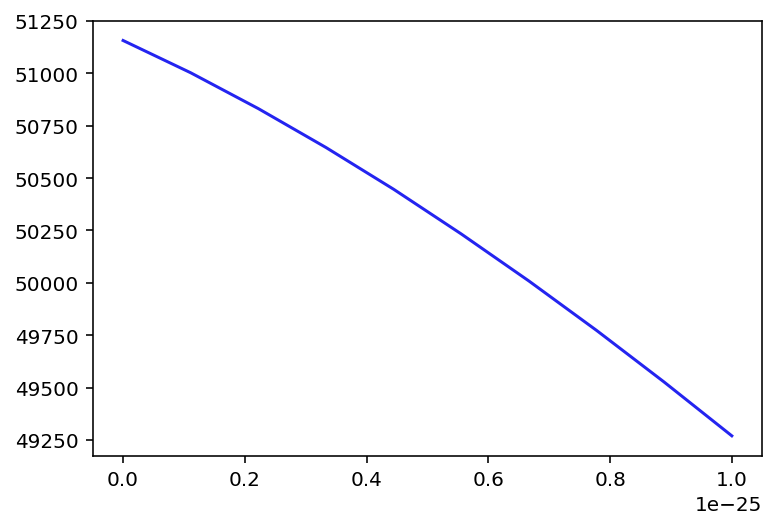

In [71]:
plt.plot(sigmas, likelihoods)

In [18]:
from cobaya.run import run
updated_info, products = run(info)

[output] Output to be read-from/written-into folder 'chains', with prefix 'class_bluebook_CMB_S4_1'
[output] Found existing products with the requested ouput prefix: 'chains/class_bluebook_CMB_S4_1'
[output] Let's try to resume/load.
[my_cl_like] Initialised external likelihood.
[my_cl_like_2] Initialised external likelihood.
[classy] Importing *global* CLASS.
[classy] *WARNING* Requesting BB for ell>50 or lensing Cl's: using a non-linear code is recommended (and you are not using any). To activate it, set 'non_linear: halofit|hmcode|...' in classy's 'extra_args'.
[classy] *WARNING* Requesting BB for ell>50 or lensing Cl's: using a non-linear code is recommended (and you are not using any). To activate it, set 'non_linear: halofit|hmcode|...' in classy's 'extra_args'.
[likelihood] The theory code will compute the following products, requested by the likelihoods: ['H0', 'Cl']
[mcmc] Resuming from previous sample!
[1] Loaded sample from 'chains/class_bluebook_CMB_S4_1.1.txt'
[mcmc] Covar

LoggedError: The given covmat is not a positive-definite, symmetric square matrix.

In [ ]:
from cobaya.run import run
updated_info, products = run(info)

[output] Output to be read-from/written-into folder 'chains', with prefix 'class_bluebook_CMB_S4_1'
[output] Found existing products with the requested ouput prefix: 'chains/class_bluebook_CMB_S4_1'
[output] Let's try to resume/load.
[my_cl_like] Initialised external likelihood.
[my_cl_like_2] Initialised external likelihood.
[classy] Importing *global* CLASS.
[classy] *WARNING* Requesting BB for ell>50 or lensing Cl's: using a non-linear code is recommended (and you are not using any). To activate it, set 'non_linear: halofit|hmcode|...' in classy's 'extra_args'.
[classy] *WARNING* Requesting BB for ell>50 or lensing Cl's: using a non-linear code is recommended (and you are not using any). To activate it, set 'non_linear: halofit|hmcode|...' in classy's 'extra_args'.
[likelihood] The theory code will compute the following products, requested by the likelihoods: ['H0', 'Cl']
[mcmc] Resuming from previous sample!
[1] Loaded sample from 'chains/class_bluebook_CMB_S4_1.1.txt'
[mcmc] Covar